#A simple autoencoder test
Bottleneck consists of a single number, which determines the fraction of the image covered in black squares

In [13]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from matplotlib import pyplot as plt

import os

In [2]:
# Decoder goes here
N_image = 64 # Size of (square) input image

def linear(x):
    # x represents the fraction of the image full of ones
    img = np.repeat(np.linspace(-1,1,28), N_image).reshape(N_image,N_image) * x
    return img

def ellipsoid(A,e,theta):
    B = A*(1.-e)
    x = np.tile(np.linspace(-1,1,N_image).reshape(1,N_image), (N_image,1))
    y = np.tile(-np.linspace(-1,1,N_image).reshape(N_image,1), (1,N_image))
    x_prime = x * np.cos(theta) - y * np.sin(theta)
    y_prime = x * np.sin(theta) + y * np.cos(theta)
    r_prime = np.sqrt((x_prime/A)**2 + (y_prime/B)**2)
    img = np.exp(-r_prime)
    return(img)

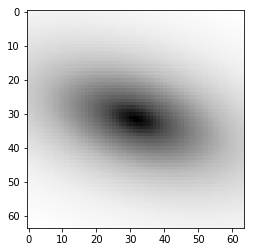

In [3]:
# And here's a test to see that the decoder does what we expect:
gal = ellipsoid(1.,0.5,0.3)
plt.imshow(gal, cmap="Greys")
plt.show()

#print gal

In [4]:
#Making dataset
N_train = 10000
noise = 0.05

A = np.random.uniform(0.1, 0.5, size = N_train)
e = np.random.uniform(0.2, 0.75, size = N_train)
theta = np.random.uniform(size = N_train)*np.pi

train_images = np.array([ellipsoid(A[i],e[i],theta[i]) + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image) \
                for i in np.arange(N_train)])

train_images = np.array([train_images]).reshape(N_train,N_image,N_image,1)
##train_images_transposed = np.array([img.transpose() for img in train_images])
##train_images = np.concatenate((train_images, train_images_transposed))
##train_images = train_images.reshape(2*N_train,N_image,N_image,1)

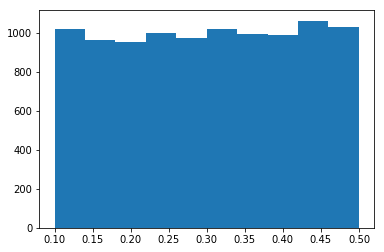

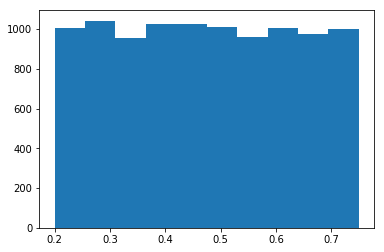

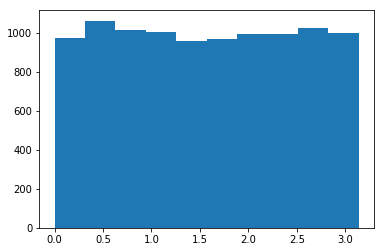

In [5]:
plt.hist(A); plt.show()
plt.hist(e); plt.show()
plt.hist(theta); plt.show()

In [6]:
print train_images.shape

(10000, 64, 64, 1)


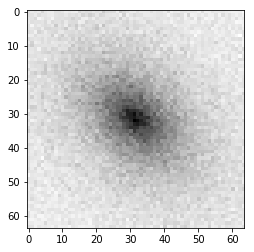

[-0.02078991 -0.06132192  0.06432606  0.06095414 -0.00724123  0.02207925
  0.0284125   0.0823244  -0.02343614 -0.04928247 -0.02154257  0.09032856
 -0.01200633 -0.02072153 -0.0388403  -0.038145   -0.08651024  0.08670098
  0.04219097  0.03621803  0.0268996   0.08887365  0.18445564  0.14044491
  0.18192912  0.24111303  0.32076137  0.40383703  0.43234982  0.49558097
  0.67068677  0.8042054   1.0336905   0.7474102   0.65776972  0.46617302
  0.32363357  0.2303794   0.24245759  0.10108333  0.1682886   0.19638019
  0.09983774  0.04690065 -0.01799718  0.03530494  0.05945638  0.06464349
  0.11736627 -0.02888561  0.02329941  0.00195699  0.06090753 -0.03789303
 -0.02767182 -0.06012428  0.0205644   0.0182279   0.04862554  0.01518989
 -0.04724992 -0.02729634  0.11615942 -0.01574811]


In [7]:
# And here's a test to check that the training images are reasonable:
plt.imshow(train_images[10,:,:,0], cmap='Greys')
plt.show()
print train_images[4,int(N_image/2),:,0]

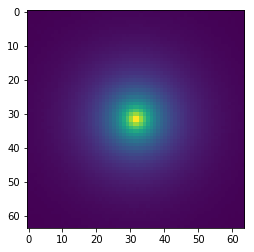

In [8]:
mean_image = np.mean(train_images,axis=0)[:,:,0]
plt.imshow(mean_image)
plt.show()

In [9]:
#Lambda Layer (Decoder, galaxies)
import math as m

def ellipsoid_layer(X):
    pi = tf.constant(m.pi)
    
    A = tf.tile(tf.reshape(X[:,0], [tf.shape(X)[0],1,1,1]), [1,N_image,N_image,1])
    e = tf.tile(tf.reshape(X[:,1], [tf.shape(X)[0],1,1,1]), [1,N_image,N_image,1])
    theta = pi * tf.tile(tf.reshape(X[:,2], [tf.shape(X)[0],1,1,1]), [1,N_image,N_image,1])
    
    #Attempt at setting bounds on parameters
    #A = A*tf.math.sigmoid(10*A)
    #e = e*tf.math.sigmoid(10*e)
    #e = e*tf.math.sigmoid(10.*(1-e))
    #theta = theta*tf.math.sigmoid(10*theta)    
    
    # possible papers:
    #https://papers.nips.cc/paper/7942-constrained-generation-of-semantically-valid-graphs-via-regularizing-variational-autoencoders.pdf
    
    B = A * (1. - e)
    
    x = tf.tile(tf.reshape(tf.linspace(-1.,1.,N_image), [1,N_image,1]), [N_image,1,1])
    y = - tf.tile(tf.reshape(tf.linspace(-1.,1.,N_image), [N_image,1,1]), [1,N_image,1])
    
    x = tf.tile(tf.reshape(x,[1,N_image,N_image,1]), [tf.shape(X)[0],1,1,1])
    y = tf.tile(tf.reshape(y,[1,N_image,N_image,1]), [tf.shape(X)[0],1,1,1])
    
    x_prime = x * tf.math.cos(theta) - y * tf.math.sin(theta)
    y_prime = x * tf.math.sin(theta) + y * tf.math.cos(theta)
    r_prime = tf.math.sqrt((x_prime/A)**2 + (y_prime/B)**2)
    
    img = tf.math.exp(-r_prime)
    
    return img

    #img = tf.tile(tf.reshape(img, [1,N_image,N_image,1]), [tf.shape(x)[0],1,1,1])
    #img = tf.tile(tf.reshape(x, [tf.shape(x)[0],1,1,1]), [1,N_image,N_image,1]) * img

In [10]:
#model = models.Sequential()
filt_size = 3
fs = filt_size
# Define layers (named, so we can nab them later)
inputs = layers.Input(shape=(N_image, N_image, 1))
conv1 = layers.Conv2D(16, (fs, fs), activation='relu', padding="same")(inputs)
conv12= layers.Conv2D(16, (fs, fs), activation='relu', padding="same")(conv1)
pool1 = layers.MaxPooling2D((2, 2)).apply(conv12)
conv2 = layers.Conv2D(32, (fs, fs), activation='relu', padding="same")(pool1)
conv22= layers.Conv2D(32, (fs, fs), activation='relu', padding="same")(conv2)
pool2 = layers.MaxPooling2D((2, 2))(conv22)
conv3 = layers.Conv2D(64, (fs, fs), activation='relu', padding="same")(pool2)
conv32= layers.Conv2D(64, (fs, fs), activation='relu', padding="same")(conv3)
pool3 = layers.MaxPooling2D((2, 2))(conv32)
flatten1 = layers.Flatten()(pool3) 
dense1 = layers.Dense(64, activation='sigmoid')(flatten1)
dense2 = layers.Dense(32, activation='sigmoid')(dense1)
dense3 = layers.Dense(3, activation='sigmoid')(dense2)

#model.add(layers.Dense(3136, activation='relu'))
#model.add(layers.Reshape((7, 7, 64)))

#model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
#model.add(layers.UpSampling2D((2, 2)))
#model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
#model.add(layers.UpSampling2D((2, 2)))
#model.add(layers.Conv2D(1, (fs, fs), activation='sigmoid', padding="same"))

#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(1))

lambda1 = layers.Lambda(lambda x:ellipsoid_layer(x))(dense3)
model    = models.Model(inputs, lambda1)
model_bn = models.Model(inputs, dense3)

model.summary()

W1010 14:33:12.777371 140177262253440 deprecation.py:506] From /home/tanmoy/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0     

In [14]:
model.compile(optimizer='RMSprop',
              loss='mean_squared_logarithmic_error',
              metrics=['accuracy']
             )
#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

checkpoint_path = 'autoencoder_2_checkpoints/autoencoder_2.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [22]:
model.fit(train_images, train_images, epochs=40, callbacks=[cp_callback])
#model.fit(train_images, train_labels/10., epochs=5)

Epoch 1/40
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00
Epoch 00001: saving model to autoencoder_2_checkpoints/autoencoder_2.ckpt
10000/10000 [==============================] - 26s 3ms/sample - loss: 0.0015 - acc: 0.0000e+00
Epoch 2/40
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00
Epoch 00002: saving model to autoencoder_2_checkpoints/autoencoder_2.ckpt
10000/10000 [==============================] - 27s 3ms/sample - loss: 0.0015 - acc: 0.0000e+00
Epoch 3/40
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00
Epoch 00003: saving model to autoencoder_2_checkpoints/autoencoder_2.ckpt
10000/10000 [==============================] - 27s 3ms/sample - loss: 0.0015 - acc: 0.0000e+00
Epoch 4/40
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00
Epoch 00004: saving model to autoencoder_2_checkpoints/autoencoder_2.ckpt
10000/10000 [==========

Epoch 32/40
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00
Epoch 00032: saving model to autoencoder_2_checkpoints/autoencoder_2.ckpt
10000/10000 [==============================] - 26s 3ms/sample - loss: 0.0014 - acc: 0.0000e+00
Epoch 33/40
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00
Epoch 00033: saving model to autoencoder_2_checkpoints/autoencoder_2.ckpt
10000/10000 [==============================] - 28s 3ms/sample - loss: 0.0014 - acc: 0.0000e+00
Epoch 34/40
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00
Epoch 00034: saving model to autoencoder_2_checkpoints/autoencoder_2.ckpt
10000/10000 [==============================] - 27s 3ms/sample - loss: 0.0014 - acc: 0.0000e+00
Epoch 35/40
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00
Epoch 00035: saving model to autoencoder_2_checkpoints/autoencoder_2.ckpt
10000/10000 [======

In [23]:
testpar = 0.5,0.2,0.5
test_img = ellipsoid(*testpar).reshape(N_image,N_image,1)# + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image,1)
#test_img = test_img[:,:,0].transpose().reshape(28,28,1)
out = model.predict(np.array([test_img]))

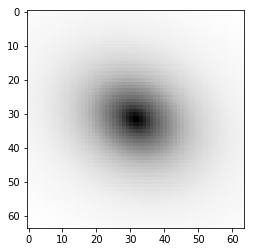

In [24]:
plt.imshow(test_img[:,:,0],cmap="Greys")
plt.show()
#print test_img[:,int(N_image/2),0]

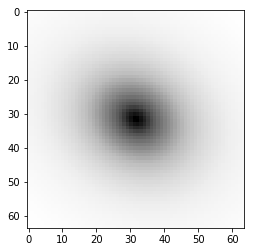

(0.5, 0.2, 0.5) [[0.48945874 0.17064391 0.17810766]]


In [25]:
plt.imshow(out[0,:,:,0], cmap="Greys")
plt.show()
#print out[0,:,15,0]
print testpar, model_bn.predict(np.array([test_img]))
#print out

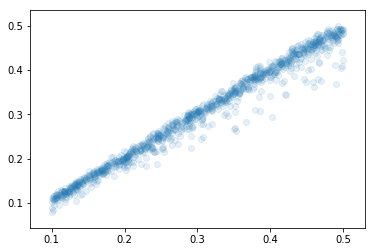

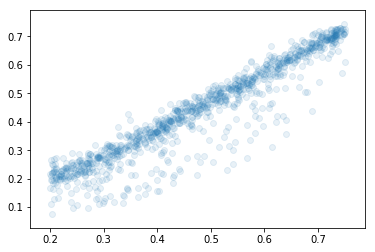

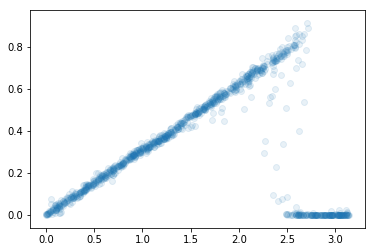

In [26]:
# Look for distribution of results from the training sample
fitvals = model_bn.predict(train_images)

plt.scatter(A[:1000],fitvals[:1000,0], alpha=0.1); plt.show()
plt.scatter(e[:1000],fitvals[:1000,1], alpha=0.1); plt.show()
plt.scatter(theta[:1000],fitvals[:1000,2], alpha=0.1); plt.show()

#plt.hist(fitvals[:,0]); plt.show()
#plt.hist(fitvals[:,1]); plt.show()
#plt.hist(fitvals[:,2]); plt.show()

In [28]:
w = model.get_weights()
warr = np.array(w)
print warr[6].shape

(3, 3, 32, 64)


In [31]:
#plt.imshow(warr[6],aspect='auto')
#plt.hist(warr[6].reshape(-1),bins=30)
print warr[1]

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [ ]:
# Run the following to see all the weights (filters) for one of the layers
#for i in np.arange(64):    
#    plt.imshow(w[2][:,:,0,i])
#    #plt.imshow(np.random.uniform(-1,1,9*9).reshape(9,9))
#    plt.show()

In [ ]:
#Lambda Layer (Decoder) (TL's copy):
def make_regions(x):
    x_int = x[1]
    print x, tf.to_float(x_int)
    img = np.zeros(N_image*N_image).reshape(N_image,N_image)
    Q = int(np.floor(x_int*N_image))
    img[:,0:Q] = 1
    return img

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.add(layers.Lambda(make_regions))

In [ ]:
model.summary()

In [ ]:
# Here's the mnist train data, for reference:

#mnist_data = np.load('mnist.npz')
#(train_images, train_labels), (test_images, test_labels) = (mnist_data['x_train'], mnist_data['y_train']), (mnist_data['x_test'], mnist_data['y_test'])

In [ ]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()


In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

In [ ]:
model.predict_classes(np.array([test_images[0]]))

In [ ]:
test_labels[0]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_images[0][:,:,0])